#### Load the Images from drive

#### Libraries

In [1]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import gymnasium as gym
from gym import spaces
import random
from collections import deque
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline

#### Labels:
* Paper: 2
* Scissor: 0
* Rock: 1

#### Load Images

In [2]:
def load_images_from_folder(folder, label, image_size=(28, 28)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, image_size)  # Resize image to match the model input
            img = img / 255.0  # Normalize image pixels to [0, 1]
            images.append(img)
            labels.append(label)
    return images, labels

img_paths={
    'rock_images':'rock',
    'scissor_images':'scissors',
    'paper_images':'paper'
}

# Load images from folders and create labels
rock_images, rock_labels = load_images_from_folder(img_paths['rock_images'], label=1)
scissor_images, scissor_labels = load_images_from_folder(img_paths['scissor_images'], label=0)
paper_images, paper_labels = load_images_from_folder(img_paths['paper_images'], label=2)

env_config = {
    'rock_images': rock_images,
    'scissor_images': scissor_images,
    'paper_images': paper_images,
}


In [3]:
def split_data(images, labels, test_size=0.3):
    return train_test_split(images, labels, test_size=test_size, random_state=42, stratify=labels)


# Split each category's data
train_rock_images, test_rock_images, train_rock_labels, test_rock_labels = split_data(rock_images, rock_labels)
train_scissor_images, test_scissor_images, train_scissor_labels, test_scissor_labels = split_data(scissor_images, scissor_labels)
train_paper_images, test_paper_images, train_paper_labels, test_paper_labels = split_data(paper_images, paper_labels)

# Combine the training splits
training_images = np.array(train_rock_images + train_scissor_images + train_paper_images)
training_labels = np.array(train_rock_labels + train_scissor_labels + train_paper_labels)

# Combine the test splits
test_images = np.array(test_rock_images + test_scissor_images + test_paper_images)
test_labels = np.array(test_rock_labels + test_scissor_labels + test_paper_labels)

# Expand image dimensions to fit the model input shape (num_samples, 28, 28, 1)
training_images = np.expand_dims(training_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

In [4]:

size=training_labels.shape[0]
sc=0
pa=0
ro=0
for i in training_labels:
  if i==0:
    sc+=1
  if i==2:
    pa+=1
  if i==1:
    ro+=1
print('sc:',round((sc/size)*100,2))
print('pa:',round((pa/size)*100,2))
print('rock:',round((ro/size)*100,2))


sc: 34.29
pa: 32.53
rock: 33.18


#### Preprocess for prediction

In [5]:
def preprocess_for_prediction(image, target_size=(28, 28)):
  # Resize the image to the target size
  image = cv2.resize(image, target_size)

  # Normalize the image
  image = image / 255.0

  # Expand the dimensions to add the channel information
  image = np.expand_dims(image, axis=-1)

  return image

#### Agent

In [6]:
class Agent:
    def __init__(self, state_size=(28,28,1), action_size=3, learning_rate=0.01, discount_factor=0.6, replay_buffer_size=50, batch_size=20):
        self.state_size = state_size
        self.action_size = action_size

        self.budget=100

        self.total_wins = 0
        self.total_losses = 0
        self.total_draw= 0

        self.earnings_history = []

        self.memory = deque(maxlen=replay_buffer_size)
        self.batch_size = batch_size
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.model = self.create_model()
        self.model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')


    def create_model(self):
        model = Sequential([
            Conv2D(64, (3, 3), activation='sigmoid', input_shape=self.state_size),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            Conv2D(128, (3, 3), activation='sigmoid'),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            Flatten(),

            Dense(1024, activation='sigmoid'),
            Dropout(0.5),

            Dense(512),
            Dense(512),
            Dense(512),
            Dense(512),
            Dense(512),
            Dense(512, activation='sigmoid'),
            Dense(self.action_size, activation='softmax')  # Output action probabilities
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy')
        return model

    def resetScores(self):
        self.total_wins = 0
        self.total_losses = 0
        self.total_draw= 0
        self.budget=100
        self.earnings_history = []

    def choose_action(self, state):
        state = np.expand_dims(state, axis=0)
        action_probs = self.model.predict(state)[0]
        action = np.random.choice(self.action_size, p=action_probs)
        return action

    def update_budget(self,value):
      self.budget-=1
      self.budget+=value
      self.calculateScore(value)
      self.earnings_history.append(self.budget)  # Track the earnings
      return

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def learn(self):
        # Check if enough samples are in the memory for a minibatch
        if len(self.memory) < self.batch_size:
            return

        # Randomly sample a minibatch from the memory
        minibatch = random.sample(self.memory, self.batch_size)
        states, targets = [], []

        # Iterate through each experience in the minibatch
        for state, action, reward, next_state, done in minibatch:
            # Initialize the target to the immediate reward
            target = reward

            # If the next state is not terminal, update the target with future discounted reward
            if not done:
                # Predict the future reward for the next state and use the maximum predicted value
                target = (reward + self.discount_factor * np.amax(self.model.predict(np.expand_dims(next_state, axis=0))[0]))

            # Predict the current Q-values for the current state
            target_f = self.model.predict(np.expand_dims(state, axis=0))

            # Update the Q-value for the action taken to the newly computed target value
            target_f[0][action] = target

            # Append the state and the target to their respective lists
            states.append(state)
            targets.append(target_f[0])

        # Fit the model on the batch of states and targets
        # This step trains the neural network to better estimate Q-values
        self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)

    def calculateScore(self,reward):
        if(reward==2):
          self.total_wins+=1
        elif reward==1:
          self.total_draw+=1
        else:
          self.total_losses+=1

    def plot_earnings(self):
        plt.plot(self.earnings_history)
        plt.title("Agent's Earnings Over Time")
        plt.xlabel("Game Rounds")
        plt.ylabel("Cumulative Earnings")
        plt.show()

#### Random Agent

In [7]:
class RandomAgent:
    def __init__(self, env_config):
        self.rock_images = env_config['rock_images']
        self.scissor_images = env_config['scissor_images']
        self.paper_images = env_config['paper_images']


    def choose_action(self):
        image = self.select_image()
        image=preprocess_for_prediction(image)
        return [self.state,image]

    def select_image(self):
        # Select a random state (rock, paper, scissors)
        self.state = random.randint(0, 2)
        # Select a random image corresponding to the selected state
        if self.state == 1:
            self.image = random.choice(self.rock_images)
        elif self.state == 0:
            self.image = random.choice(self.scissor_images)
        else:
            self.image = random.choice(self.paper_images)
        return self.preprocess_image(self.image)

    def preprocess_image(self, image: np.ndarray) -> np.ndarray:
        # Apply vertical flip with probability p1
        if random.random() < 0.5:
            image = np.flipud(image)
        # Apply horizontal flip with probability p2
        if random.random() < 0.5:
            image = np.fliplr(image)
        # Add random noise to the image
        noise = np.random.normal(0, 0.05 * 255, image.shape)
        image = np.clip(image + noise, 0, 255)
        return image

    def preprocess_for_prediction(image, target_size=(28, 28)):
      # Resize the image to the target size
      image = cv2.resize(image, target_size)

      # Normalize the image
      image = image / 255.0

      # Expand the dimensions to add the channel information
      image = np.expand_dims(image, axis=-1)

      return image


#### Game Enviroment

In [8]:
class RockPaperScissorsEnv(gym.Env):
    def __init__(self):

        self.action_space = spaces.Discrete(3)  # States: 0: Rock, 1: Paper, 2: Scissors
        self.observation_space = spaces.Box(low=0, high=1, shape=(28, 28, 1), dtype=np.float32)  # Normalized grayscale image of rock/scissor/paper

    def reset(self):
        return

    def step(self, action1: int, action2: int) -> tuple:
        # Define the game rules
        reward = self.game_rules(action1, action2)

        # The round ends after the agent's action
        done = True
        return (reward, done)

    def game_rules(self, state, action):
        """
        SCISSOR 0 
        PAPER = 2
        ROCK = 1
        """
        """Rock beats Scissors (1 beats 0),
          Scissors beats Paper (0 beats 2),
           Paper beats Rock (2 beats 1)
        """
        if (state == 1 and action == 0) or (state == 0 and action == 2) or (state == 2 and action == 1):
            return 0  # Agent loses
        elif state == action:
            return 1  # Draw
        else:
            return 2  # Agent wins


#### Init

In [9]:
env = RockPaperScissorsEnv()
agent=Agent()
rAgent = RandomAgent(env_config)

#### Learn

In [10]:

import pickle
with open('model.pkl','rb') as f:
  agent=pickle.load(f)



In [11]:
num_episodes = 2000  # Set the number of games you want to play
episode=0
# 5500 games learned -> 7 hours of training


# init the first state
rAction,state = rAgent.choose_action()

for e in range(num_episodes):
    episode += 1
    done = False

    while not done:

        # get The image
        action = agent.choose_action(state)

        # get reward
        reward, done = env.step(rAction,action)

        # get next state
        next_rAction,next_state = rAgent.choose_action()

        # Store this experience
        agent.remember(state, action, reward, next_state, done)

        rAction = next_rAction
        state = next_state

        agent.update_budget(reward) # Update the budget of the agent

        print(f"Game {e}, Action taken: {action}, Reward: {reward}, Total Reward: {agent.budget}")
        print(f"Total wins: {agent.total_wins}, Total draw: {agent.total_draw}, Total losses: {agent.total_losses}")

        # Learn from the experience
        if done:
            agent.learn()



1/1 [==============================] - 0s 209ms/step
Game 0, Action taken: 0, Reward: 0, Total Reward: 244
Total wins: 1840, Total draw: 1742, Total losses: 1696
1/1 [==============================] - 0s 23ms/step
Game 1, Action taken: 0, Reward: 1, Total Reward: 244
Total wins: 1840, Total draw: 1743, Total losses: 1696
1/1 [==============================] - 0s 21ms/step
Game 2, Action taken: 0, Reward: 2, Total Reward: 245
Total wins: 1841, Total draw: 1743, Total losses: 1696
1/1 [==============================] - 0s 21ms/step
Game 3, Action taken: 0, Reward: 0, Total Reward: 244
Total wins: 1841, Total draw: 1743, Total losses: 1697
1/1 [==============================] - 0s 22ms/step
Game 4, Action taken: 0, Reward: 2, Total Reward: 245
Total wins: 1842, Total draw: 1743, Total losses: 1697
1/1 [==============================] - 0s 21ms/step
Game 5, Action taken: 0, Reward: 1, Total Reward: 245
Total wins: 1842, Total draw: 1744, Total losses: 1697
1/1 [============================

In [7]:
import pickle
with open('model.pkl','rb') as f:
  agent = pickle.load(f)
  


In [12]:
with open('model.pkl','wb') as f:
  pickle.dump(agent,f)

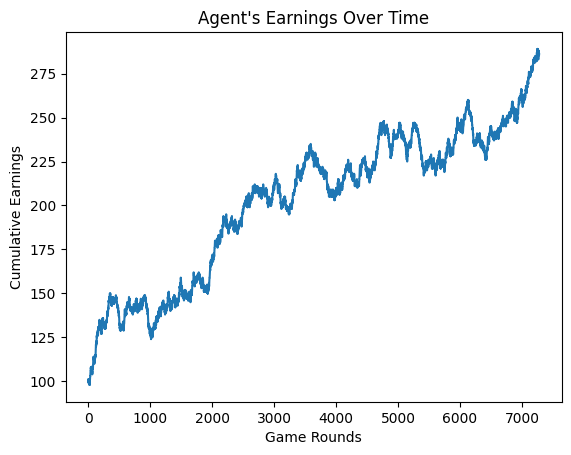

DRAW:2421
LOST:2335
WIN:2521


In [13]:
agent.plot_earnings()
print(f'DRAW:{agent.total_draw}\nLOST:{agent.total_losses}\nWIN:{agent.total_wins}')


#### Game

In [15]:
# Set the number of games you want to play_game
num_episodes =100
agent.resetScores()
episode_game=0

for e in range(num_episodes):
    episode_game+=1
    done = False

    while not done:
        rAction,state = rAgent.choose_action()

        action = agent.choose_action(state)

        reward, done = env.step(rAction,action)

        agent.update_budget(reward)

        print(f"Game {episode_game}, Action taken: {action}, Reward: {reward}, Total Reward: {agent.budget}")
        print(f"Total wins: {agent.total_wins}, Total draw: {agent.total_draw}, Total losses: {agent.total_losses}")



1/1 [==============================] - 0s 71ms/step
Game 1, Action taken: 0, Reward: 2, Total Reward: 101
Total wins: 1, Total draw: 0, Total losses: 0
1/1 [==============================] - 0s 73ms/step
Game 2, Action taken: 0, Reward: 0, Total Reward: 100
Total wins: 1, Total draw: 0, Total losses: 1
1/1 [==============================] - 0s 70ms/step
Game 3, Action taken: 0, Reward: 1, Total Reward: 100
Total wins: 1, Total draw: 1, Total losses: 1
1/1 [==============================] - 0s 70ms/step
Game 4, Action taken: 0, Reward: 0, Total Reward: 99
Total wins: 1, Total draw: 1, Total losses: 2
1/1 [==============================] - 0s 68ms/step
Game 5, Action taken: 0, Reward: 1, Total Reward: 99
Total wins: 1, Total draw: 2, Total losses: 2
1/1 [==============================] - 0s 67ms/step
Game 6, Action taken: 0, Reward: 2, Total Reward: 100
Total wins: 2, Total draw: 2, Total losses: 2
1/1 [==============================] - 0s 70ms/step
Game 7, Action taken: 0, Reward: 1, To

#### Image from me

In [ ]:
photo_images=['/content/sample_data/hand_scis.png']
def getImages():
  for filename in photo_images:
      img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
      if img is not None:
              img = cv2.resize(img, (28,28))  # Resize image to match the model input
              img = img / 255.0  # Normalize image pixels to [0, 1]
              label=0
      return img, label

image,label=getImages()

image=env.preprocess_image(image)

for i in range(50):
  processed_state = preprocess_for_prediction(image)

  action = agent.choose_action(processed_state)


# 2 paper
#0 scissor
#1 rock
  result=env.game_rules(label,action)
  if(result==0):
    print("DRAW")
  elif(result==2):
    print("WIN")
  else:
    print("LOSSES")
